In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.scDEED as scd
import BacSC.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1652 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.936
Zero inflation of aggregated data: 0.831


## Attach transcription units

In [6]:
tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

,PAO1_ID,TU_ID,Regulation - transcription units of gene
0,PA0001,1,gyrB // recF // dnaN // dnaA
1,PA0002,1,gyrB // recF // dnaN // dnaA
2,PA0003,1,gyrB // recF // dnaN // dnaA
3,PA0004,1,gyrB // recF // dnaN // dnaA
4,PA0005,2,PA0006 // lptA
...,...,...,...
5692,PA5566,3750,PA5566
5693,PA5567,3751,PA5567
5694,PA5568,3752,PA5568
5695,PA5569,3753,rpmH // rnpA


In [7]:
data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,PAO1_ID,TU_ID,Regulation - transcription units of gene
PAO1_ID,,,,,,,,,,,
PA0001,Gene Expression,PA01,842,1.230630,0.802284,49.031477,2033.0,7.617760,PA0001,1,gyrB // recF // dnaN // dnaA
PA0002,Gene Expression,PA01,645,0.904964,0.644463,60.956416,1495.0,7.310550,PA0002,1,gyrB // recF // dnaN // dnaA
PA0003,Gene Expression,PA01,998,1.796005,1.028192,39.588378,2967.0,7.995644,PA0003,1,gyrB // recF // dnaN // dnaA
PA0004,Gene Expression,PA01,563,0.702179,0.531909,65.920097,1160.0,7.057037,PA0004,1,gyrB // recF // dnaN // dnaA
PA0005,Gene Expression,PA01,254,0.252421,0.225079,84.624697,417.0,6.035481,PA0005,2,PA0006 // lptA
...,...,...,...,...,...,...,...,...,...,...,...
PA5566,Gene Expression,PA01,26,0.019370,0.019185,98.426150,32.0,3.496508,PA5566,3750,PA5566
PA5567,Gene Expression,PA01,254,0.266949,0.236612,84.624697,441.0,6.091310,PA5567,3751,PA5567
PA5568,Gene Expression,PA01,846,1.214286,0.794930,48.789346,2006.0,7.604396,PA5568,3752,PA5568


### Filter cells

--> filter based on mean absolute standard deviation

In [8]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1544
True      108
Name: count, dtype: int64
Total number of cells: 1652
Number of cells after filtering: 1544


AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells'

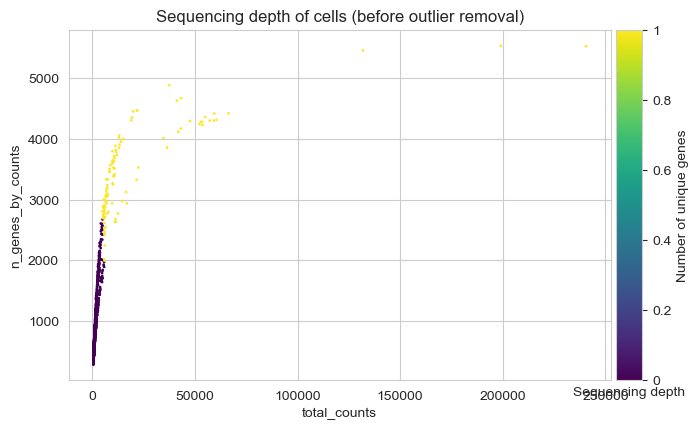

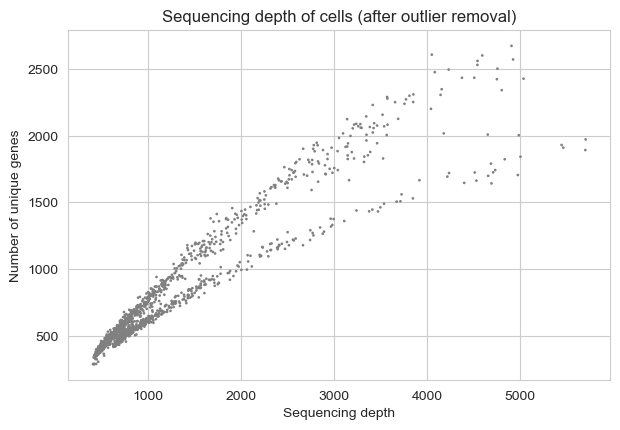

In [9]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [10]:
data_gene.layers["counts"] = data_gene.X.copy()

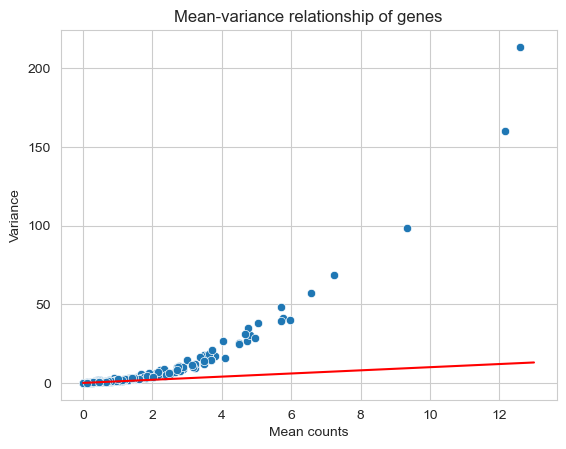

In [11]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [12]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5553
Fitting feature 200/5553
Fitting feature 300/5553
Fitting feature 400/5553
Fitting feature 500/5553
Fitting feature 600/5553
Fitting feature 700/5553
Fitting feature 800/5553
Fitting feature 900/5553
Fitting feature 1000/5553
Fitting feature 1100/5553
Fitting feature 1200/5553
Fitting feature 1300/5553
Fitting feature 1400/5553
Fitting feature 1500/5553
Fitting feature 1600/5553
Fitting feature 1700/5553
Fitting feature 1800/5553
Fitting feature 1900/5553
Fitting feature 2000/5553
Fitting feature 2100/5553
Fitting feature 2200/5553
Fitting feature 2300/5553
Fitting feature 2400/5553
Fitting feature 2500/5553
Fitting feature 2600/5553
Fitting feature 2700/5553
Fitting feature 2800/5553
Fitting feature 2900/5553
Fitting feature 3000/5553
Fitting feature 3100/5553
Fitting feature 3200/5553
Fitting feature 3300/5553
Fitting feature 3400/5553
Fitting feature 3500/5553
Fitting feature 3600/5553
Fitting feature 3700/5553
Fitting feature 3800/5553
Fitting feature 3900/

In [13]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts")

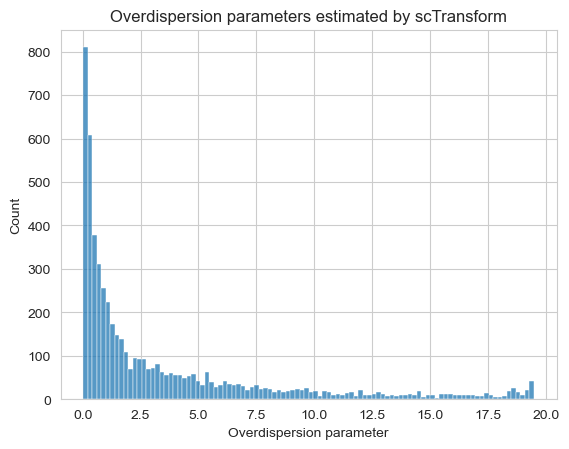

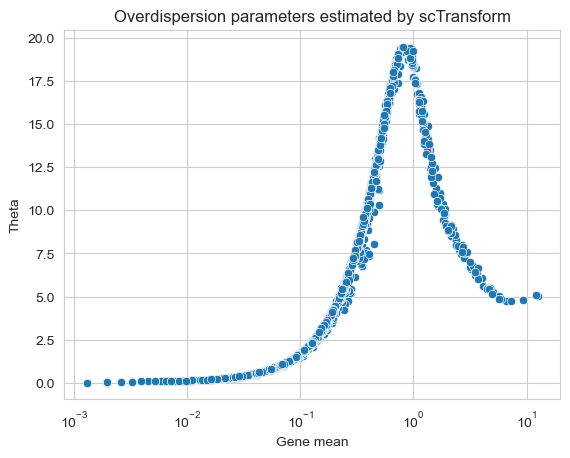

In [14]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

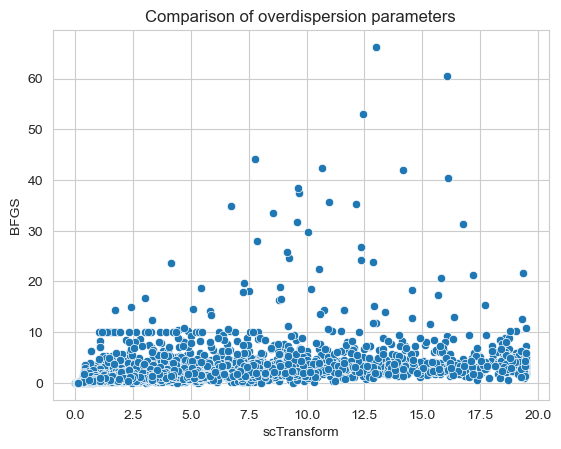

Correlation: [[1.         0.46628001]
 [0.46628001 1.        ]]


In [15]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [16]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [17]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

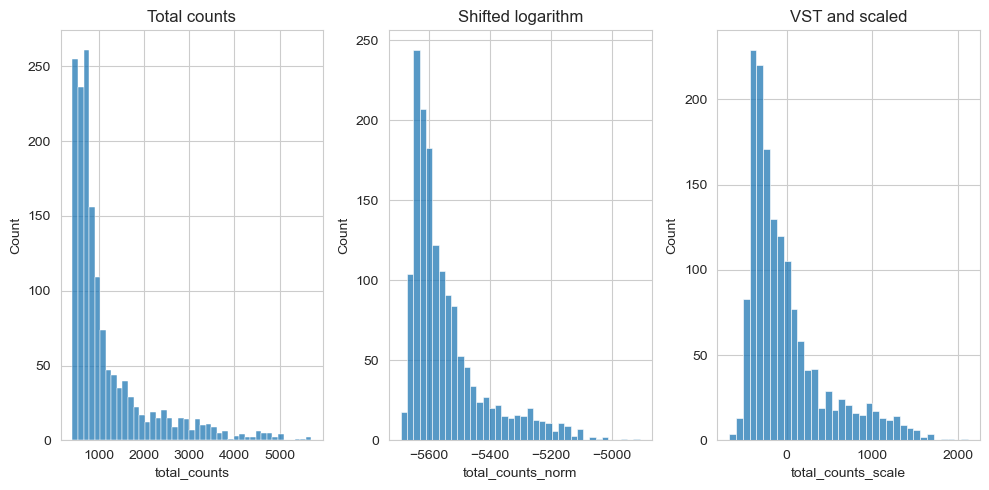

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [19]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1544 × 5513
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'is_scd_outlier', 'mean', 'std'
    layers: 'counts'


In [20]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

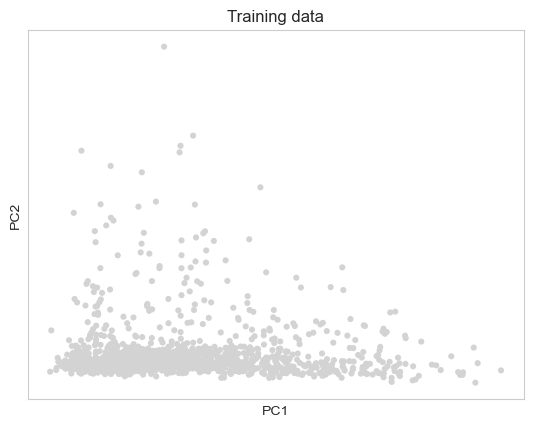

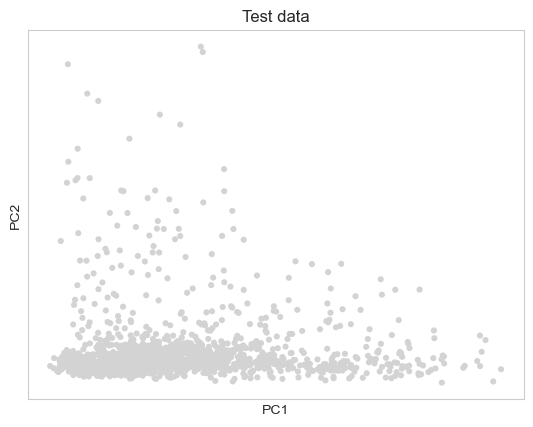

In [21]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [22]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


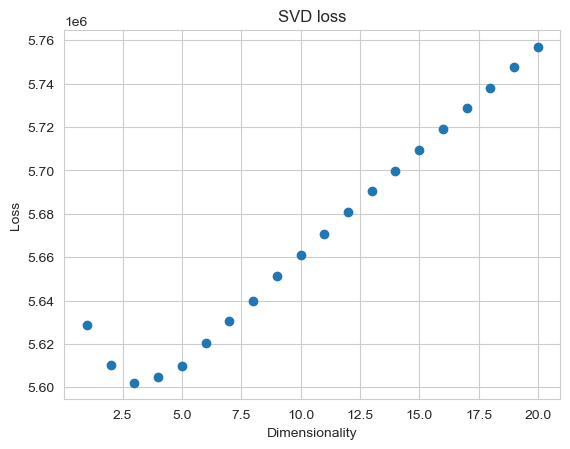

In [23]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

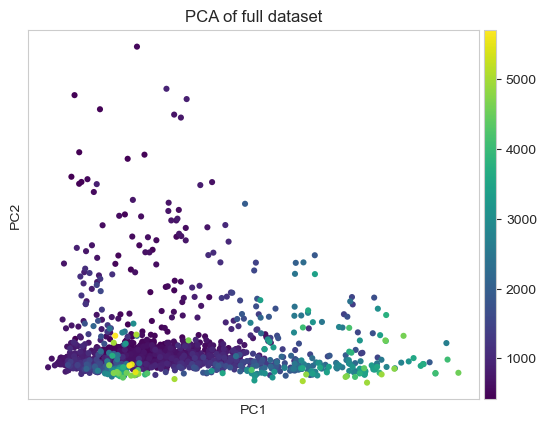

In [24]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [25]:
print(data_gene)
print(data_gene.X[:5, :5])

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'PAO1_ID', 'TU_ID', 'Regulation - transcription units of gene', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'is_scd_outlier', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
[[-0.77027187 -0.6039984  -0.91739197 -0.54885512 -0.31519969]
 [-0.77027187 -0.6039984   0.47983333 -0.54885512 -0.31519969]
 [ 1.80740878 -0.6039984  -0.91739197 -0.54885512 -0.31519969]
 [ 0.5775711  -0.6039984   0.28778502 -0.54885512 -0.31519969]
 [ 0.39024452 -0.6039984   1.03704939 -0.54885512 -0.31519969]]


## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [26]:
importlib.reload(scd)

n_neighborss = [30, 35, 40]
min_dists = [0.1, 0.3]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, embedding_method="UMAP", similarity_percent=0.5, save_path="repr_test")

calculating (30, 0.1) - run 1/6
calculating (30, 0.3) - run 2/6
calculating (35, 0.1) - run 3/6
calculating (35, 0.3) - run 4/6
calculating (40, 0.1) - run 5/6
calculating (40, 0.3) - run 6/6


Optimal number of neighbors: 40
Optimal min_dist: 0.3


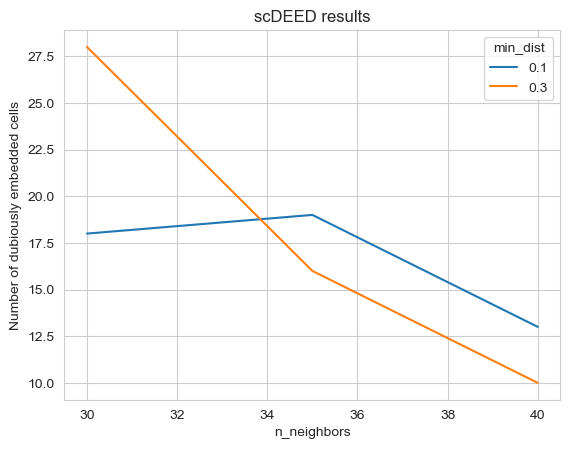

In [27]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

calculating (30, 0.1) - run 1/6
calculating (30, 0.3) - run 2/6
calculating (35, 0.1) - run 3/6
calculating (35, 0.3) - run 4/6
calculating (40, 0.1) - run 5/6
calculating (40, 0.3) - run 6/6
Optimal number of neighbors: 30
Optimal min_dist: 0.1


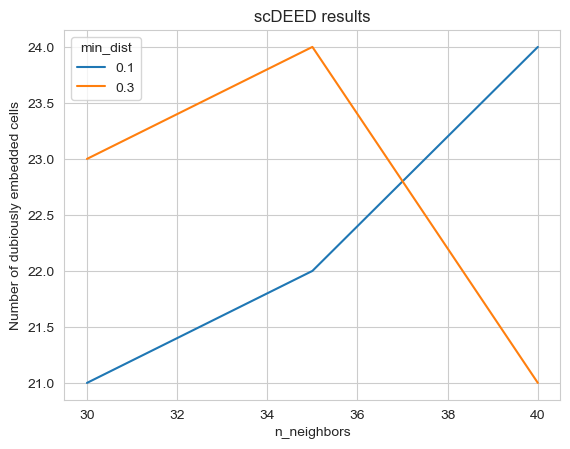

In [28]:
importlib.reload(scd)

n_neighborss = [30, 35, 40]
min_dists = [0.1, 0.3]

scdeed_result2, rel_scores2, null_rel_scores2, reliabilities2, n_neighbors_opt2, min_dist_opt2 = scd.scdeed_parameter_selection(
    data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=1234, embedding_method="UMAP", similarity_percent=0.5,
    save_path="repr_test2")
print(f"Optimal number of neighbors: {n_neighbors_opt2}")
print(f"Optimal min_dist: {min_dist_opt2}")

sns.lineplot(data=scdeed_result2, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()